In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import zt_ind_solve_power
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go

In [2]:
sns.set(font_scale=1.2, palette='Set2')

# A/B-тестирование внедрения улучшенной рекомендательной системы

1. [Описание проекта](#project_description)

2. [Описание и предобработка данных](#data_description_and_preparation)

3. [Оценка корректности проведения AB-теста](#check_of_the_correctness)

4. [Исследовательский анализ данных](#EDA)

5. [Оценка результатов A/B-теста](#results_analysis)

6. [Общий вывод](#overall_conclusion)

## Описание проекта <a id='project_description'></a>

Было проведено тестирование изменений, связанных с внедрением улучшенной рекомендательной системы. Ожидается, что за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:

* конверсия в просмотр карточки товара

* конверсия в просмотр корзины

* конверсия в покупку

Задачи:

* оценить корректность проведения теста

* проанализировать результаты теста

## Описание и предобаботка данных <a id='data_description_and_preparation'></a>

Таблица `marketing_events` – календарь маркетинговых событий на 2020 год:

* `name` – название маркетингового события

* `regions` – регионы, в которых проводилась рекламная кампания

* `start_dt` – дата начала кампании

* `finish_dt` – дата завершения кампании

In [3]:
marketing_events = pd.read_csv(
    '../datasets/ab_project_marketing_events.csv', 
    parse_dates=['start_dt', 'finish_dt']
)

In [4]:
marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [5]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [6]:
print(f'Кол-во дубликатов: {marketing_events.duplicated().sum()}')

Кол-во дубликатов: 0


In [7]:
marketeng_events_in_regions = {}
for regions in marketing_events['regions']:
    for region in regions.split(', '):
        if region not in marketeng_events_in_regions:
            marketeng_events_in_regions[region] = 0
        marketeng_events_in_regions[region] += 1
        
print('Количество маркетинговых кампаний по регионам за все время:')
for region, marketing_events_count in sorted(marketeng_events_in_regions.items(), key=lambda item: -item[1]):
    print(f'{region}: {marketing_events_count}')

Количество маркетинговых кампаний по регионам за все время:
APAC: 9
EU: 7
CIS: 7
N.America: 6


<br>

Таблица `users` – все пользователи, зарегистрировавшиеся в интернет-магазине:

* `user_id` – идентификатор пользователя

* `first_date` – дата регистрации

* `region` – регион пользователя

* `device` – устройство, с которого происходила регистрация

In [8]:
users = pd.read_csv('../datasets/final_ab_new_users.csv', parse_dates=['first_date'])

In [9]:
users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [10]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


In [11]:
print(f'Кол-во дубликатов: {users.duplicated().sum()}')

Кол-во дубликатов: 0


In [12]:
for col in ['region', 'device']:
    print(f'Распределение пользователей по столбцу {col}:')
    print(users[col].value_counts(normalize=True), end='\n\n')

Распределение пользователей по столбцу region:
EU           0.749518
N.America    0.148300
CIS          0.051107
APAC         0.051075
Name: region, dtype: float64

Распределение пользователей по столбцу device:
Android    0.445791
PC         0.252685
iPhone     0.202971
Mac        0.098553
Name: device, dtype: float64



<br>

Таблица `user_events` – события новых пользователей:

* `user_id` – идентификатор пользователя

* `event_dt` – дата и время события

* `event_name` – тип события

* `details` – дополнительные данные о событии. Например, для покупок, `purchase`, в этом поле хранится стоимость покупки в долларах

In [13]:
user_events = pd.read_csv('../datasets/final_ab_events.csv', parse_dates=['event_dt'])

In [14]:
user_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [15]:
user_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


In [16]:
print(f'Кол-во дубликатов: {user_events.duplicated().sum()}')

Кол-во дубликатов: 0


Как и должно быть пропусков в `details` нет только у события покупки:

In [17]:
user_events['details'].isnull().groupby(user_events['event_name']).sum()

event_name
login           189552
product_cart     62462
product_page    125563
purchase             0
Name: details, dtype: int64

<br>

Таблица `participants` – участники тестов:

* `user_id` – идентификатор пользователя

* `ab_test` – название теста

* `group` – группа пользователя

In [18]:
participants = pd.read_csv('../datasets/final_ab_participants.csv')

In [19]:
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [20]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [21]:
print(f'Кол-во дубликатов: {participants.duplicated().sum()}')

Кол-во дубликатов: 0


In [22]:
print('Распределение пользователей по группам в рамках кажого теста:')
participants.groupby('ab_test')['group'].value_counts(normalize=True)

Распределение пользователей по группам в рамках кажого теста:


ab_test                  group
interface_eu_test        A        0.504107
                         B        0.495893
recommender_system_test  A        0.570661
                         B        0.429339
Name: group, dtype: float64

## Оценка корректности проведения A/B-теста <a id='check_of_the_correctness'></a>

Проверим соответсвие данных требованиям технического задания:

* Набор новых пользователей проводился с 2020-12-07 по 2020-12-21

In [23]:
(
    participants[participants['ab_test'] == 'recommender_system_test']
    .merge(users, on='user_id')
    .agg({'first_date': ['min', 'max']})
)

,first_date
min,2020-12-07
max,2020-12-21


Все верно.

* тест проводился с 2020-12-07 по 2021-01-04

In [24]:
(
    participants[participants['ab_test'] == 'recommender_system_test']
    .merge(user_events, on='user_id')
    .agg({'event_dt': ['min', 'max']})
)

,event_dt
min,2020-12-07 00:05:57
max,2020-12-30 12:42:57


Отсутствуют логи по последним дням. Может логи перестали собирать или добавлять, может пользователи просто не совершали никаких действий.

* аудитория: 15% новых пользователей из региона EU

In [25]:
eu_users = users[users['region'] == 'EU']

len(
    participants[participants['ab_test'] == 'recommender_system_test']
    .merge(eu_users, on='user_id')
) / len(eu_users)

0.13725956343202939

Получилось чуть меньше, чем планировалось – около 14%.

* ожидаемое количество участников теста: 6000

In [26]:
n_participants = (
    participants.loc[participants['ab_test'] == 'recommender_system_test']
    .merge(user_events, on='user_id')['user_id'].nunique()
)

n_participants

3675

В тестировании поучаствовало в 1,6 раза меньше пользователей, чем планировалось.

<br>

Проверим другие обязательные и важные условия корректного проведения A/B-теста:

* отсутствие пользователей, участвующих в двух группах теста одновременно

In [27]:
rs_group_A = participants.loc[
    (participants['ab_test'] == 'recommender_system_test') & (participants['group'] == 'A'),
    'user_id'
]

rs_group_B = participants.loc[
    (participants['ab_test'] == 'recommender_system_test') & (participants['group'] == 'B'),
    'user_id'
]

were_in_two_groups_of_rs_test = set(rs_group_A) & set(rs_group_B)

print(f'Кол-во пользователей, принявших участие в двух группах теста: {len(were_in_two_groups_of_rs_test)}')

Кол-во пользователей, принявших участие в двух группах теста: 0


Все верно.

* отсутствие пользователей, участвующих в конкурирующих тестах

Результаты могут быть искажены, если пользователь из нашего теста также попал в группу B теста по изменению интерфейса.

In [28]:
rs = participants.loc[
    participants['ab_test'] == 'recommender_system_test',
    'user_id'
]

i_eu_group_B = participants.loc[
    (participants['ab_test'] == 'interface_eu_test') & (participants['group'] == 'B'),
    'user_id'
]

were_in_rs_test_and_i_eu_group_B_pct = len(set(rs) & set(i_eu_group_B)) / n_participants

print(
    'Доля пользователей, участвующих в нашем тесте и группе B из теста по изменению интерфейса:', 
    f'{were_in_rs_test_and_i_eu_group_B_pct:.3f}'
)

Доля пользователей, участвующих в нашем тесте и группе B из теста по изменению интерфейса: 0.213


Каждый четвертый пользователь принял участие в конкурирующем тесте.

* репрезентативность групп по признакам

In [29]:
def check_sample_ration_mismatch(col):
    rs_users = (
        participants[participants['ab_test'] == 'recommender_system_test']
        .merge(users, on='user_id')
    )
    
    groups_distribution_by_col = pd.crosstab(
        index=rs_users['group'],
        columns=rs_users[col],
        values=rs_users['user_id'],
        aggfunc='count', normalize='index'
    )
    
    print(f'Распределение пользователей групп по признаку {col}:')
    display(groups_distribution_by_col)
    

In [30]:
check_sample_ration_mismatch('region')

Распределение пользователей групп по признаку region:


region,APAC,CIS,EU,N.America
group,,,,
A,0.009676,0.006538,0.950314,0.033473
B,0.012165,0.010428,0.944387,0.033021


In [31]:
check_sample_ration_mismatch('device')

Распределение пользователей групп по признаку device:


device,Android,Mac,PC,iPhone
group,,,,
A,0.437238,0.097542,0.264383,0.200837
B,0.455683,0.090372,0.241919,0.212026


Пользователи групп распределены примерно одинаково по признакам региона и устройства. Также видно, что аудитория нашего теста не польностью состоит из пользователей региона EU.

* распределение сплитов по дням примерно одинаковое

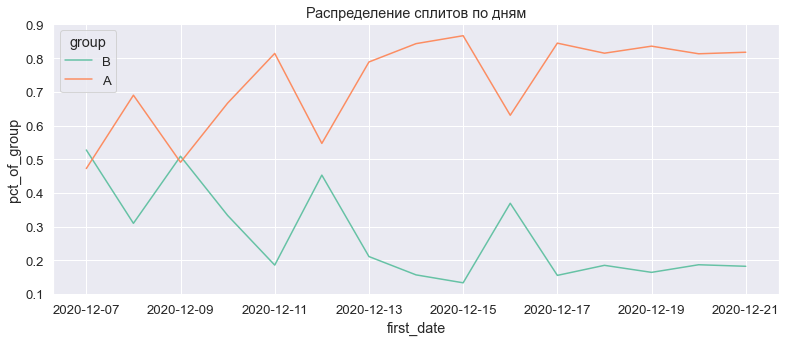

In [32]:
splits_by_date = (
    participants[
        (participants['ab_test'] == 'recommender_system_test') & 
        (participants['user_id'].isin(user_events['user_id'].unique()))
    ]
    .merge(users, on='user_id')
    .groupby('first_date')['group'].value_counts(normalize=True)
    .rename('pct_of_group')
    .reset_index()
)

plt.figure(figsize=(13, 5))
sns.lineplot(data=splits_by_date, x='first_date', y='pct_of_group', hue='group')
plt.title('Распределение сплитов по дням');

Наблюдается цикличность в привлечении пользователей. Сначала распределение по группам стремится к 50/50, затем происходит перевес в пользу группы A и снова попытка соблюсти баланс групп. С увеличением времени теста дисбаланс в рамках каждого цикла становится все больше. С 17 декабря по конец теста сохраняется дисбаланс 85/15.

* время теста не совпадает с маркетинговыми и другими активностями

In [33]:
marketing_events.sort_values(by=['start_dt', 'finish_dt'])

,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


По времени и аудитории наш тест пересекается с маркетинговой активностью Christmas&New Year Promo:

In [34]:
marketing_events.loc[0]

name         Christmas&New Year Promo
regions                 EU, N.America
start_dt          2020-12-25 00:00:00
finish_dt         2021-01-03 00:00:00
Name: 0, dtype: object

Посмотрим, какая доля пользователей совершила хотя бы одно действие во время этой маркетинговой активности:

In [35]:
marketing_event = marketing_events.loc[0]
marketing_regions = marketing_event['regions'].split(', ')
users_in_regions = users[users['region'].isin(marketing_regions)]
users_affected_by_marketing_event = (
    user_events.loc[
        user_events['event_dt'].between(
            marketing_event['start_dt'], marketing_event['finish_dt'], inclusive='left'
        ),
        ['user_id']
    ]
    .merge(users_in_regions['user_id'], on='user_id')
    .merge(participants, on='user_id')
    .groupby('ab_test')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'n_users'})
)
marketing_name = marketing_event['name']
print(f'{marketing_name}:')
if not users_affected_by_marketing_event.empty:
    display(users_affected_by_marketing_event)
else:
    print('ни один пользователь не совершил хотя бы одно действие')
print()

Christmas&New Year Promo:


,n_users
ab_test,
interface_eu_test,4065
recommender_system_test,1220


In [36]:
1220 / n_participants

0.33197278911564626

Каждый третий пользователь совершил хотя бы одно действие во время маркетинговой активности Christmas&New Year Promo.

* отсутствие пробелов в событиях пользователей

Например, если пользователь совершил покупку, у него обязательно должны быть события просмотра карточки и корзины.

In [37]:
rs_users = (
    participants.loc[participants['ab_test'] == 'recommender_system_test', ['user_id', 'group']]
    .merge(user_events, on='user_id')
)

events_count_by_user = (
    pd.pivot_table(
        data=rs_users, 
        index=['group', 'user_id'], 
        columns='event_name', 
        values='event_dt', 
        aggfunc='count'
    ).fillna(0)
)

events_count_by_user

event_name              login  product_cart  product_page  purchase
group user_id                                                      
A     0010A1C096941592    4.0           0.0           4.0       4.0
      00341D8401F0F665    2.0           0.0           0.0       0.0
      003DF44D7589BBD4    5.0           5.0           5.0       0.0
      00505E15A9D81546    5.0           0.0           0.0       0.0
      006E3E4E232CE760    3.0           0.0           3.0       0.0
...                       ...           ...           ...       ...
B     FE76759FE6BF8C68    5.0           5.0           5.0       5.0
      FE8F9858BBE502D9    1.0           1.0           0.0       0.0
      FEA0C585A53E7027    1.0           1.0           1.0       0.0
      FF8CF7057415EB29    2.0           0.0           2.0       0.0
      FFF28D02B1EACBE1    3.0           3.0           3.0       0.0

[3675 rows x 4 columns]

Уже на этой таблице видны пропуски событий. Например, у первого пользователя отсуствует событи просмотра корзины, хотя он совершил 4 покупки.

Посчитаем, сколько таких несостыковок по событиям:

In [38]:
missed_events = pd.DataFrame(columns=['wrong_difference', 'events_count'])
events_order = ['login', 'product_page', 'product_cart', 'purchase']

for i in range(len(events_order) - 1):
    wrong_difference = events_order[i] + ' < ' + events_order[i + 1]
    events_count = sum(events_count_by_user[events_order[i]] < events_count_by_user[events_order[i + 1]])
    missed_events = missed_events.append(
        {'wrong_difference': wrong_difference, 'events_count': events_count}, 
        ignore_index=True
    )
    
missed_events['events_pct'] = missed_events['events_count'] / len(rs_users)

missed_events

,wrong_difference,events_count,events_pct
0,login < product_page,0,0.0
1,product_page < product_cart,394,0.015953
2,product_cart < purchase,787,0.031865


Пропусков событий немного.

<br>

Теперь решим, что делать с ошибками в требованиях ТЗ и условиях правильного проведения A/B-теста, которые можно скорректировать.

In [39]:
df = (
    participants.loc[participants['ab_test'] == 'recommender_system_test', ['user_id', 'group']]
    .merge(users[['user_id', 'first_date', 'region']], on='user_id')
    .merge(user_events[['user_id', 'event_dt', 'event_name']], on='user_id')
)

* аудитория теста не состоит полностью из пользователей региона EU

* наличие пользователей, участвующих в конкурирующих тестах

* наличие пользователей, совершивших хотя бы одно действие во время маркетинговой активности Christmas&New Year Promo

In [40]:
print('Распределение пользователей по региону:')
df[['user_id', 'region']].drop_duplicates()['region'].value_counts(normalize=True)

Распределение пользователей по региону:


EU           0.947211
N.America    0.032381
APAC         0.012245
CIS          0.008163
Name: region, dtype: float64

In [41]:
were_in_rs_test_and_i_eu_group_B_pct = df.loc[df['user_id'].isin(set(rs) & set(i_eu_group_B)), 'user_id'].nunique() \
/ df['user_id'].nunique()

print(
    'Доля пользователей, участвующих в нашем тесте и группе B из теста по изменению интерфейса:', 
    f'{were_in_rs_test_and_i_eu_group_B_pct:.3f}'
)

Доля пользователей, участвующих в нашем тесте и группе B из теста по изменению интерфейса: 0.117


In [42]:
had_events_during_marketing_event = df.loc[df['event_dt'] >= pd.to_datetime('2020-12-25'), 'user_id'].unique()
had_events_during_marketing_event_pct = len(had_events_during_marketing_event) / df['user_id'].nunique()

print(
    'Доля пользователей, сделавших хотя бы одно действие во время маркетинговой активности Christmas&New Year Promo:', 
    f'{had_events_during_marketing_event_pct:.2f}',
    sep='\n'
)

Доля пользователей, сделавших хотя бы одно действие во время маркетинговой активности Christmas&New Year Promo:
0.34


In [43]:
print('Доля пользователей, попавших под влияние маркетинговой кампании:')
df.groupby('group').apply(lambda x: x.loc[x['event_dt'] >= pd.to_datetime('2020-12-25'), 'user_id'].nunique()) \
/ df.groupby('group')['user_id'].nunique()

Доля пользователей, попавших под влияние маркетинговой кампании:


group
A    0.365854
B    0.256466
dtype: float64

Допустимо оставить пользователей только из региона EU и удалить пользователей, принявших участие в конкурирующих тестах, так как тогда выборка несильно уменьшится. Пользователей, попавших под воздействие маркетинговой кампании, около трети выборки. Перед нами выбор меньшего из двух зол: сильно сократить выборку или оставить влияние маркетинговой кампании. Поскольку размер выборку изначально меньше указанного в ТЗ и было решено удалить других пользователей, этих оставим.

In [44]:
df = df[(df['region'] == 'EU') & (~df['user_id'].isin(set(rs) & set(i_eu_group_B)))]

* пропуски логов событий

Заполним пропуски на текущем этапе следующим первым непропущенным значением

In [45]:
events_count_by_user.columns.names = [None]
events_count_by_user.columns = events_order
events_count_by_user.reset_index(inplace=True)

events_count_by_user = events_count_by_user.fillna(method='bfill', axis=1).fillna(0)

<br>

По ТЗ эффект нужно измерять за 14 дней с момента регистрации, поэтому стоит удалить все события, которые произошли позднее 14 дня с момента регистрации.

In [46]:
events_after_14_days = sum(df['event_dt'] - df['first_date'] >= timedelta(days=14)) / len(df)

print(f'Доля событий через 14 дней после регистрации: {events_after_14_days:.3f}')

Доля событий через 14 дней после регистрации: 0.035


In [47]:
df = df[df['event_dt'] - df['first_date'] < timedelta(days=14)]

<br>

In [48]:
n_users = df['user_id'].nunique()
print(f'Доля оставшихся пользователей после предобработки: {n_users/3675:.2f}')

Доля оставшихся пользователей после предобработки: 0.83


## Исследовательский анализ данных <a id='EDA'></a>

###  Кол-во событий на пользователя

In [49]:
events_count_by_user['total_events'] = events_count_by_user[events_order].sum(axis=1)

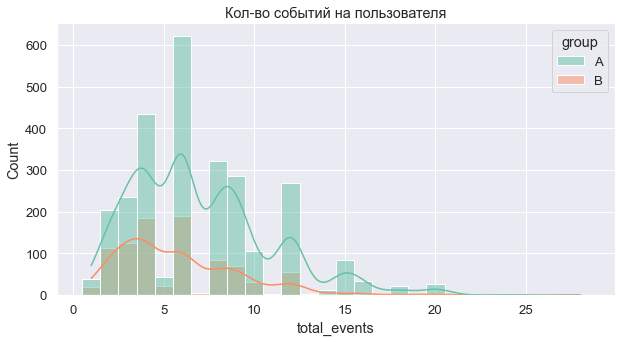

In [50]:
plt.figure(figsize=(10, 5))
sns.histplot(data=events_count_by_user, x='total_events', hue='group', discrete=True, kde=True)
plt.title('Кол-во событий на пользователя');

Количество событий на пользователя распределено примерно одинаково по группам.

### Кол-во событий по дням

In [51]:
df['event_date'] = df['event_dt'].dt.date

events_count_by_date_and_group = (
    df.groupby(['group', 'event_date'], as_index=False)
    .agg({'event_name': 'count'})
    .rename(columns={'event_name': 'total_events'})
)

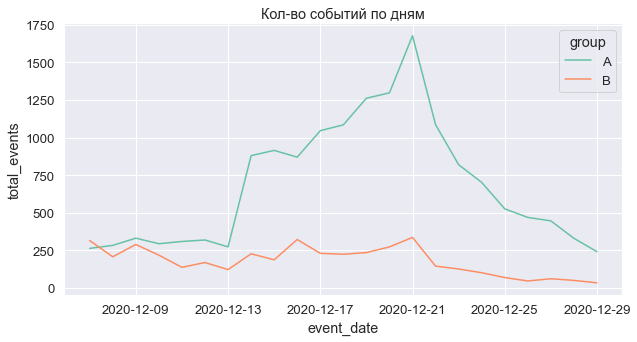

In [52]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=events_count_by_date_and_group, x='event_date', y='total_events', hue='group')
plt.title('Кол-во событий по дням');

14 декабря произошел аномальный скачок числа событий у группы A.

In [53]:
users_without_events_by_date = (
    users[~users['user_id'].isin(df['user_id'].unique())]
    .merge(participants[participants['ab_test'] == 'recommender_system_test'], on='user_id')
    .groupby(['first_date', 'group'], as_index=False)
    .agg({'user_id': 'count'})
    .rename(columns={'user_id': 'n_users'})
)

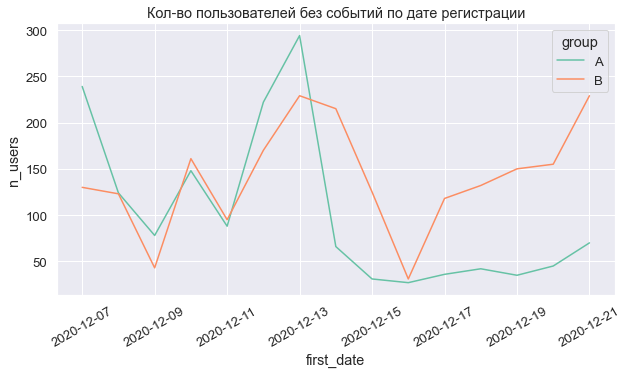

In [54]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=users_without_events_by_date, x='first_date', y='n_users', hue='group')
plt.xticks(rotation=30)
plt.title('Кол-во пользователей без событий по дате регистрации');

По каждой дате регистрации есть пользователи без событий. Скорее всего был баг из-за которого события не учитывались. 14 декабря число пользователей без событий резко снизилось в группе A (как раз когда у нас аномально увеличилось количество событий у группы A). Скорее всего баг поправили, но только у группы A.

### Конверсия

In [55]:
# подчсет количества типов событий у пользователей по дням
events_count_by_user_and_date = pd.pivot_table(
    data=df, 
    index=['group', 'event_date', 'user_id'], 
    columns='event_name', 
    values='event_dt', 
    aggfunc='count'
)

# заполнение пропусков в событиях
events_count_by_user_and_date = events_count_by_user_and_date[events_order]
events_count_by_user_and_date = events_count_by_user_and_date.fillna(method='bfill', axis=1).fillna(0)

# подсчет количества событий по дням и группам
events_count_by_user_and_date.columns.names = [None]
events_count_by_user_and_date.reset_index(inplace=True)
events_count_by_date = (
    events_count_by_user_and_date.sort_values(by='event_date')
    .groupby(['group', 'event_date'])[events_order].sum()
)

# подсчет кумулятивного количества событий по дням и группам
cum_events_count_by_date = events_count_by_date.groupby('group').cumsum()
cum_conversions_by_date_1 = cum_events_count_by_date.div(cum_events_count_by_date['login'], axis=0)
cum_conversions_by_date_1['n'] = cum_events_count_by_date['login']
cum_conversions_by_date_1.reset_index(inplace=True)

cum_conversions_by_date_2 = pd.melt(
    cum_conversions_by_date_1, 
    id_vars=['group', 'event_date'], value_vars=['product_page', 'product_cart', 'purchase'], 
    var_name='name', value_name='conversion'
)

display(cum_conversions_by_date_1.head())
display(cum_conversions_by_date_2.head())

,group,event_date,login,product_page,product_cart,purchase,n
0,A,2020-12-07,1.0,0.786885,0.467213,0.278689,122.0
1,A,2020-12-08,1.0,0.815686,0.443137,0.247059,255.0
2,A,2020-12-09,1.0,0.812346,0.464198,0.261728,405.0
3,A,2020-12-10,1.0,0.800370,0.473198,0.266174,541.0
4,A,2020-12-11,1.0,0.791908,0.468208,0.260116,692.0


,group,event_date,name,conversion
0,A,2020-12-07,product_page,0.786885
1,A,2020-12-08,product_page,0.815686
2,A,2020-12-09,product_page,0.812346
3,A,2020-12-10,product_page,0.800370
4,A,2020-12-11,product_page,0.791908


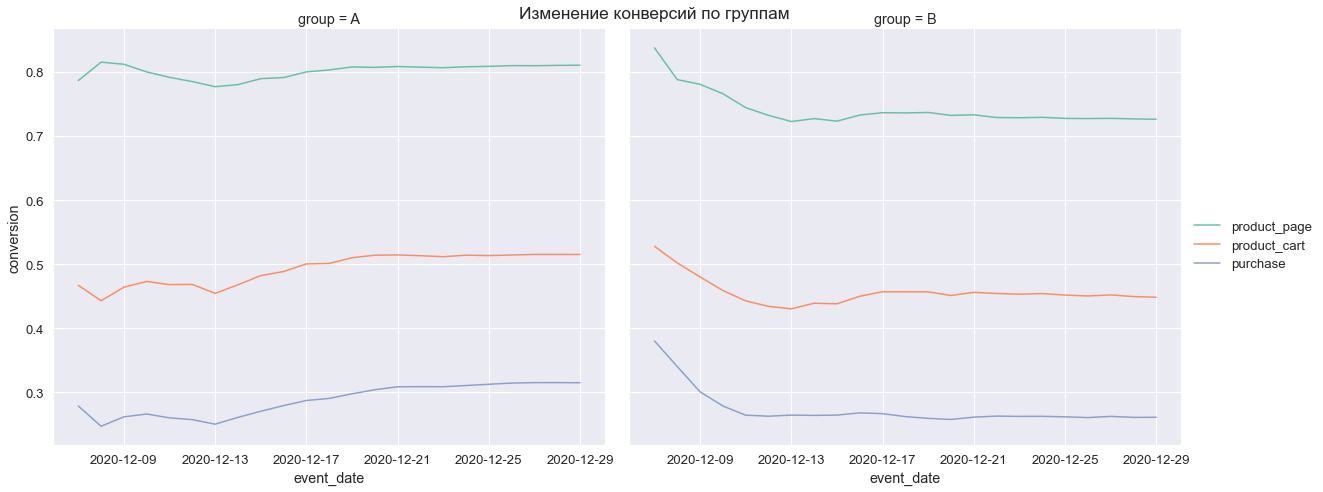

In [56]:
g = sns.FacetGrid(data=cum_conversions_by_date_2, col='group', sharex=True, height=7, aspect=1.2)
g.map_dataframe(sns.lineplot, x='event_date', y='conversion', hue='name')
g.add_legend()
g.fig.suptitle('Изменение конверсий по группам');

По всем этапам видно, что в первые дни конверсия больше у группы B, затем конверсия стабильно лучше в группе A.

In [57]:
events_count_by_user = pd.melt(
    frame=events_count_by_user_and_date, 
    id_vars=['group', 'user_id'],
    value_vars=events_order,
    var_name='event_name',
    value_name='events_count'
)
events_count_by_user = events_count_by_user[events_count_by_user['events_count'] > 0]

funnel = (
    events_count_by_user
    .groupby(['group', 'event_name'])
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'n_users'})
    .reset_index()
)

funnel = funnel.sort_values('event_name', key=lambda s: s.apply(events_order.index))

funnel

,group,event_name,n_users
0,A,login,2279
4,B,login,771
2,A,product_page,1863
6,B,product_page,583
1,A,product_cart,1186
5,B,product_cart,367
3,A,purchase,734
7,B,purchase,219


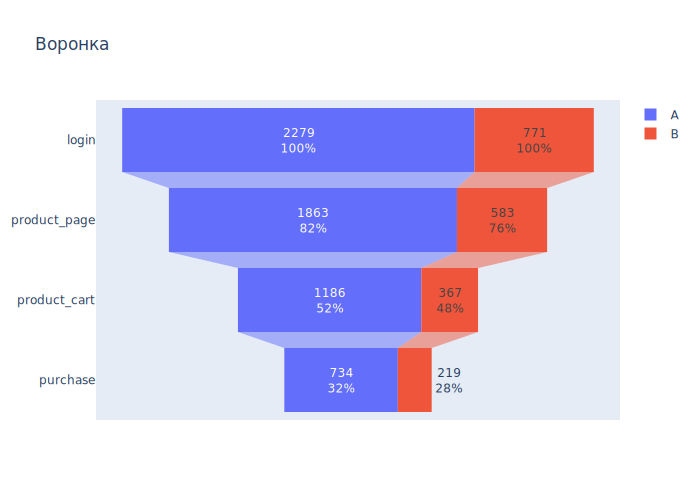

In [58]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    name='A',
    y=events_order,
    x=funnel.loc[funnel['group'] == 'A', 'n_users'],
    textinfo="value+percent initial")
)
fig.add_trace(go.Funnel(
    name='B',
    y=events_order,
    x=funnel.loc[funnel['group'] == 'B', 'n_users'],
    textinfo="value+percent initial")
)
fig.update_layout(title={'text': 'Воронка'})
fig.show('svg')

На всех этапах воронка уже у группы B.

## Оценка результатов A/B-теста <a id='results_analysis'></a>

Проверим гипотезы

* о различии конверсии в просмотр карточки продукта между группами

    $H_0: p_{product\_page\_A} = p_{product\_page\_B}$

    $H_1: p_{product\_page\_A} \ne p_{product\_page\_B}$
    
    
* о различии конверсии в просмотр корзины между группами

    $H_0: p_{product\_cart\_A} = p_{product\_cart\_B}$

    $H_1: p_{product\_cart\_A} \ne p_{product\_cart\_B}$
    
    
* о различии конверсии в покупку между группами

    $H_0: p_{product\_purchase\_A} = p_{product\_purchase\_B}$

    $H_1: p_{product\_purchase\_A} \ne p_{product\_purchase\_B}$
    
Для этого используем z-тест пропорций (т.к. меет дело с биномиальным распределением) и уровень значимости 0.05.

In [59]:
cum_events_count_by_date.reset_index(inplace=True)
cum_events_count_by_date = pd.pivot_table(data=cum_events_count_by_date, index='event_date', columns='group')
cum_events_count_by_date.columns = cum_events_count_by_date.columns.map('_'.join)
cum_events_count_by_date.reset_index(inplace=True)
for event_name in events_order:
    cum_events_count_by_date[event_name + '_lift'] = (
        cum_events_count_by_date[event_name + '_B'] / cum_events_count_by_date['login_B'] \
        - cum_events_count_by_date[event_name + '_A'] / cum_events_count_by_date['login_A']
    ) / (cum_events_count_by_date[event_name + '_A'] / cum_events_count_by_date['login_A'])

cum_events_count_by_date.head()

,event_date,login_A,login_B,product_cart_A,product_cart_B,product_page_A,product_page_B,purchase_A,purchase_B,login_lift,product_page_lift,product_cart_lift,purchase_lift
0,2020-12-07,122.0,142.0,57.0,75.0,96.0,119.0,34.0,54.0,0.0,0.064994,0.130467,0.364540
1,2020-12-08,255.0,241.0,113.0,121.0,208.0,190.0,63.0,82.0,0.0,-0.033474,0.133000,0.377198
2,2020-12-09,405.0,379.0,188.0,182.0,329.0,296.0,106.0,114.0,0.0,-0.038583,0.034497,0.149251
3,2020-12-10,541.0,488.0,256.0,224.0,433.0,374.0,144.0,136.0,0.0,-0.042451,-0.029969,0.047017
4,2020-12-11,692.0,560.0,324.0,248.0,548.0,417.0,180.0,148.0,0.0,-0.059685,-0.054145,0.016032


In [60]:
def get_results(col):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))
    
    # график изменения конверсии по дням
    sns.lineplot(
        data=cum_conversions_by_date_1,
        x='event_date',
        y=col,
        hue='group',
        ax=axes[0]
    )
    axes[0].set_title('Изменение конверсии по дням')
    
    # график изменения лифта
    sns.lineplot(
        data=cum_events_count_by_date,
        x='event_date',
        y=col+'_lift',
        ax=axes[1]
    )
    axes[1].set_title('Изменение лифта по дням')
    
    # график изменения p-value по дням
    data = cum_events_count_by_date[['event_date', 'login_A', 'login_B', col + '_A', col + '_B']].copy()
    data['p-value'] = data.apply(
        lambda day: proportions_ztest(
            count=np.array([day[col + '_A'], day[col + '_B']]),
            nobs=np.array([day['login_A'], day['login_B']])
        )[1], axis=1
    )
    sns.lineplot(data=data, x='event_date', y='p-value')
    axes[2].axhline(y=0.05, color='r', linestyle='--', label='$\u03B1=0.05$')
    axes[2].set_title('Изменение p-value по дням')
    
    fig.subplots_adjust(hspace=0.4)
    plt.show()
    
    
    # информация про лифт, эффект и mde
    last_day = cum_conversions_by_date_1.sort_values(by='event_date')[-2:]
    last_day_A = last_day[last_day['group'] == 'A']
    last_day_B = last_day[last_day['group'] == 'B']

    conversion_A = last_day_A[col].values
    conversion_B = last_day_B[col].values
    
    lift = (conversion_B - conversion_A) / conversion_A
    effect_size = (conversion_B - conversion_A) / np.sqrt(conversion_A * (1 - conversion_A))
    mde = zt_ind_solve_power(
        nobs1=last_day_A['n'].values, 
        ratio=last_day_B['n'].values / last_day_A['n'].values, 
        alpha=0.05, power=0.8
    )

    display(pd.DataFrame({'lift': lift, 'effect_size': effect_size, 'mde': mde}))

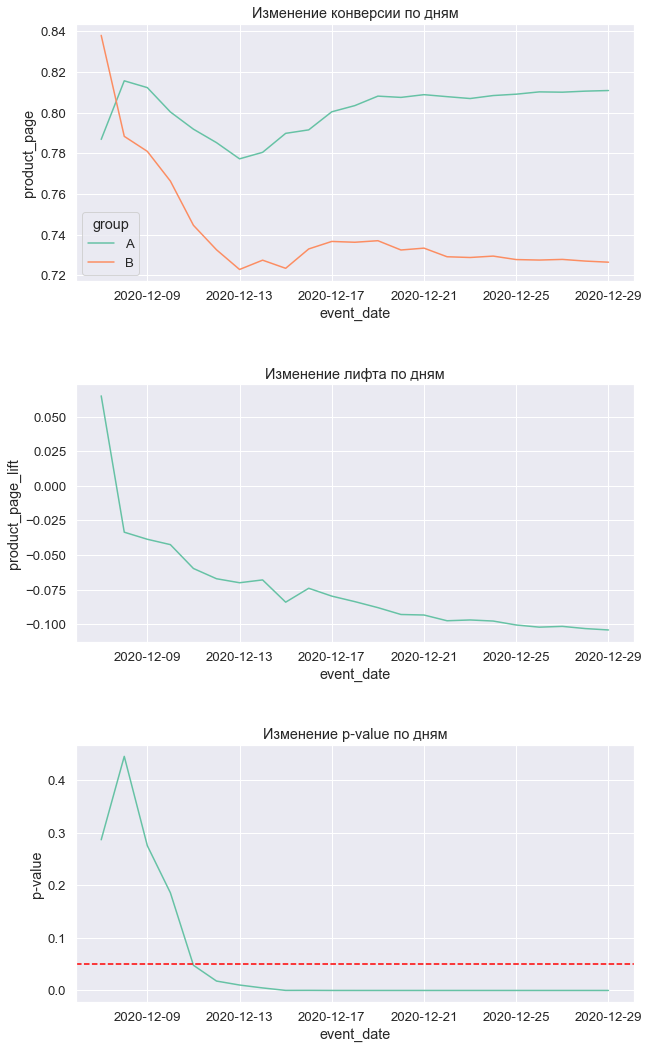

,lift,effect_size,mde
0,-0.10409,-0.215557,0.070921


In [61]:
get_results('product_page')

Размер эффекта по модулю больше mde и p-value устойчиво меньше 0.05. Можно считать, что эффект закономерен.

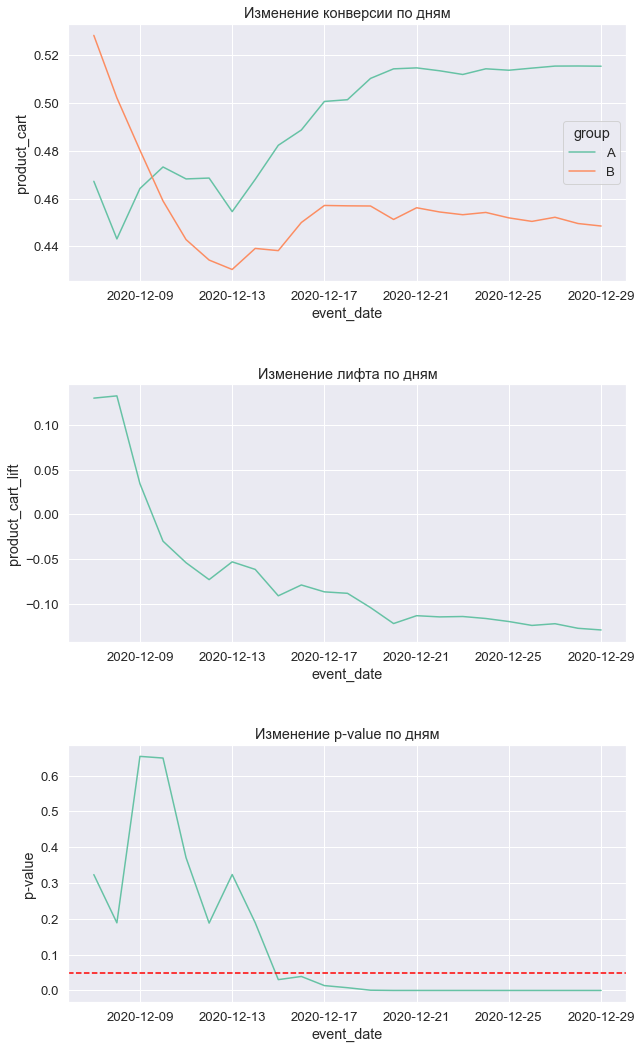

,lift,effect_size,mde
0,-0.129553,-0.133578,0.070921


In [62]:
get_results('product_cart')

Размер эффекта по модулю больше mde и p-value устойчиво меньше 0.05. Можно считать, что эффект закономерен.

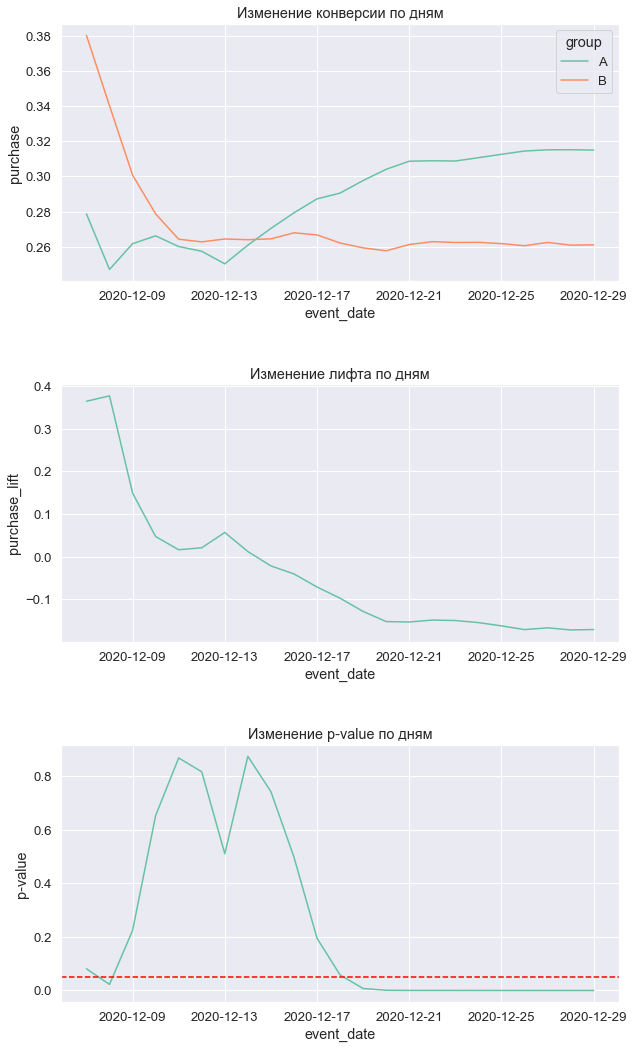

,lift,effect_size,mde
0,-0.171234,-0.116119,0.070921


In [63]:
get_results('purchase')

Размер эффекта по модулю больше mde и p-value устойчиво меньше 0.05. Можно считать, что эффект закономерен.

## Общий вывод <a id='overall_conclusion'></a>

В проведении теста были обнаружены следующие ошибки:
    
* отсутствуют логи с 2020-12-31 по 2021-01-04

* новых пользователей из региона EU чуть меньше, чем планировалось (13,7% вместо 15%)

* аудитория не польностью состоит из пользователей региона EU

* в 1,6 раза меньше пользователей, чем ожидалось

* распределение сплитов по дням разное

* каждый четвертый пользователь принял участие в конкурирующем тесте

* каждый третий пользователь совершил хотя бы одно действие во время маркетинговой активности Christmas&New Year Promo

* есть пропуски промежуточных событий

* по каждой дате регистрации есть пользователи без событий. 14 декабря число пользователей без событий резко снизилось в группе A, скорее всего баг поправили только у группы A

<br>

Принятые меры по корректировке ошибок:

* удаление пользователей из регионов кроме EU

* удаление пользователей, принявших участие в конкрирующем тесте

* восстановление пропусков промежуточных событий

* удаление событий, которые произошли позднее 14 дня с момента регистрации

Пользователей, попавших под воздействие маркетинговой кампании, было решено не удалять, так как размер выборки тогда сократился бы очень сильно и у нас уже меньше пользователей, чем требовалось по ТЗ.

<br>

Пришлось удалить много наблюдений, часть ошибок не было возможным исправить. Как итог, к результатам теста мало доверия. Рекомендуется исправить все ошибки и перезапустить тест.

<br>

Метрики показали статистически значимое ухудщение:

|metric|lift|
|---|---|
|product_page_conversion|-0.10409|
|product_cart_conversion|-0.129553|
|purchase_conversion|-0.171234|